<a href="https://colab.research.google.com/github/rosshalpin/clip-guided-scene-arrangement/blob/main/Contrastive_Text_Inputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Thu Aug 25 21:22:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
try:
  import stable_baselines3
  import sb3_contrib
  import clip
  from plot_image_grid import image_grid
except ModuleNotFoundError:
  !pip install stable-baselines3[extra]
  !pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib
  !pip install git+https://github.com/openai/CLIP.git
  !wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/main/docs/tutorials/utils/plot_image_grid.py
  import stable_baselines3
  import sb3_contrib
  import clip
  from plot_image_grid import image_grid

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'

!ln -s /content/drive/My\ Drive/Colab\ Notebooks/ $nb_path

sys.path.insert(0,nb_path)

!ln -s /content/gdrive/My\ Drive/ /mydrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ln: failed to create symbolic link '/content/notebooks/Colab Notebooks': File exists
ln: failed to create symbolic link '/mydrive': File exists


In [4]:
# need_pytorch3d=False
# try:
#     import pytorch3d
# except ModuleNotFoundError:
#     need_pytorch3d=True
# if need_pytorch3d:
#     import torch
#     if torch.__version__.startswith("1.10.") and sys.platform.startswith("linux"):
#         # We try to install PyTorch3D via a released wheel.
#         pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
#         version_str="".join([
#             f"py3{sys.version_info.minor}_cu",
#             torch.version.cuda.replace(".",""),
#             f"_pyt{pyt_version_str}"
#         ])
#         !pip install --target=$nb_path fvcore iopath
#         !pip install --target=$nb_path --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
#     else:
#         # We try to install PyTorch3D from source.
#         !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
#         !tar xzf 1.10.0.tar.gz
#         os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
#         !pip install --target=$nb_path 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [231]:
import os
import torch
import matplotlib.pyplot as plt

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.ops import sample_points_from_meshes

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, join_meshes_as_batch, join_meshes_as_scene, Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    AmbientLights,
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from torch import cuda

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [5]:
# Set paths
DATA_DIR = '/content/drive/My Drive/DissertationProject_v0.0/data'

In [6]:
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [503]:
from pytorch3d.renderer import (
  HardPhongShader
)

IMG_SIZE = (256,256)

class SceneObject():
    def __init__(self, mesh, scale=1):
      new_mesh = mesh.clone().scale_verts(scale)
      self._mesh = new_mesh
      self._scale = scale
      self._position = self._mesh_position()
      self._prev_position = self._mesh_position()

    @property
    def mesh(self):
      return self._mesh

    @property
    def position(self):
      return self._position

    @position.setter
    def position(self, value):
      offset = [round(a-b,3) for a, b in zip(value, self._position)]
      self._set_position_helper(offset)

    def _mesh_position(self):
      return [round(float(((c.cpu()[0]+c.cpu()[1])/2)), 3) for c in self._mesh.get_bounding_boxes()[0]]

    def _set_position_helper(self, value):
      self._prev_position = self._position
      offset = self._mesh.verts_padded().new_tensor(value).expand(self._mesh.verts_packed().shape)
      self._mesh = self._mesh.offset_verts(offset)
      self._position = self._mesh_position()

    def translate(self, value):
      self._set_position_helper(value)

    def reset_pos(self):
      self.position = self._prev_position

class Scene():
  def __init__(self, meshes: list, azim, elev, dist):
    self.AZIM = azim
    self.ELEV = elev
    self.num_cameras = max(len(self.AZIM), len(self.ELEV))
    self._meshes = meshes
    self.CAMERA_DIST = dist
    self._scene = join_meshes_as_scene(meshes).extend(self.num_cameras)
    self.device = device

  @property
  def scene(self):
    return self._scene

  @scene.setter
  def scene(self, value):
    self._scene = join_meshes_as_scene(value).extend(self.num_cameras)

  @property
  def _lights(self):
    return PointLights(device=device, location=[[0.0, 5.0, 0.0]])
    # return AmbientLights(device=self.device)

  @property
  def _cameras(self):
    R, T = look_at_view_transform(dist=self.CAMERA_DIST, azim=self.AZIM, elev=self.ELEV)
    return FoVPerspectiveCameras(device=self.device, R=R, T=T)

  @property
  def renderer(self):
    return MeshRenderer(
        rasterizer=MeshRasterizer(
            raster_settings=RasterizationSettings(
              image_size=IMG_SIZE, 
              faces_per_pixel=1,
              bin_size=None
            )
        ),
        shader=HardPhongShader(
            device=self.device
        )
    )
  
  def render(self):
    return self.renderer(self.scene, cameras=self._cameras, lights=self._lights).cpu().numpy()


In [11]:
from itertools import product, groupby

DIRECTIONS = list(product(range(-1, 2), repeat=3))
ALL_DIRECTIONS = []
ALL_DIRECTIONS += [[round(a * i,2) for a in b] for b in DIRECTIONS for i in np.linspace(0.1,1,4)]
ALL_DIRECTIONS.sort()
ALL_DIRECTIONS = list(ALL_DIRECTIONS for ALL_DIRECTIONS,_ in groupby(ALL_DIRECTIONS))
ACTIONS_MAP = {
  i: ALL_DIRECTIONS[i] for i in range(len(ALL_DIRECTIONS))
}

In [509]:
import time
from gym import Env
from gym.spaces import Box, Discrete, Tuple
import random
import copy
from math import isnan
from PIL import Image
from torch import tensor
import math
import torchvision.transforms as transforms
from scipy.stats import wilcoxon, ttest_ind, ttest_rel, mannwhitneyu
from operator import itemgetter
device = "cuda" if torch.cuda.is_available() else "cpu"

class CustomTrain(Env):
  def __init__(self, limit=None):

    self.pos_space = Tuple((
      Box(-10,10,shape=(1,)),
      Box(-2,10,shape=(1,)),
      Box(-10,10,shape=(1,)),
    ))

    img_in = Image.open(f"{DATA_DIR}/images/empty_room.jpeg").convert('RGB')
    resize = transforms.Resize(IMG_SIZE)
    self.background_img = resize(img_in)

    fruit_mesh = self.load_mesh(f"{DATA_DIR}/fruit_mesh/pear_export.obj")
    table_mesh = self.load_mesh(f"{DATA_DIR}/table_mesh/GenericClassicTable001.obj")
    fruit_object = SceneObject(fruit_mesh, scale=0.25)

    table_object = SceneObject(table_mesh, scale=8)
    table_object.position=[0,-3,0]

    self.model, self.preprocess = clip.load("ViT-B/32", device=device)
    self.model.cuda().eval()

    self.text_snippets = ["A photo of a fruit placed on a table", "a photo of an empty table", "a photo of a fruit placed on the floor, below a table", "a photo of a fruit thrown in the air above a table"]
    self.limit = limit
    self.rounds = 0
    self.total_reward = -1

    # self.camera_config = {
    #   'azim': torch.linspace(0, 180, 4),
    #   'elev': [20],
    #   'dist': 10.0
    # }

    self.camera_config = {
      'azim': [0,90,180,270],
      'elev': [15, 10, 20, 20],
      'dist': 9.0
    }

    self.action_space = Discrete(len(ACTIONS_MAP)) #Box(low=-1, high=1, shape=(3,)) # MultiBinary(n=6)
    self.input_objs = [fruit_object, table_object]
    self.objs =  [copy.deepcopy(obj) for obj in self.input_objs]

    self.get_similarity()

    start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    while self.check_on_camera(start_pos):
      start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    self.objs[0].position = start_pos


    self.num_cameras = self.scene.num_cameras

    # self.observation_space = Box(low=0, high=1, shape=(self.num_cameras,))
    self.observation_space = Box(low=0, high=1, shape=(len(self.text_snippets),))
    
    self.state = self.objs[0].position

    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.prev_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)

    self.best_scene = None
    self.best_images = None
    self.images = None

    self.limit_box = [[-10,-2,-10],[10,10,10]]

    self.prev_best = 0
    self.prev = 0

  def check_on_camera(self, pos):
    center = tensor(np.reshape(pos, (1,1,3)),dtype=torch.float32, device=device)
    xy = self.scene._cameras.transform_points(center)[:, :, :2].cpu().numpy()
    out_of_view = False
    for j in range(4):
      pix_pos = [((i + 1.0) * 256 - 1.0)/2.0 for i in xy[j,0]]
      out_of_view = any(n <= 0 or n >= 256 for n in pix_pos)
      if out_of_view:
        break
    return out_of_view

  def load_mesh(self, input_path) -> Meshes:
    # # Setup
    if torch.cuda.is_available():
        cdevice = torch.device("cuda:0")
        torch.cuda.set_device(cdevice)
    else:
        cdevice = torch.device("cpu")
    obj_filename = os.path.join(DATA_DIR, input_path)
    return load_objs_as_meshes([obj_filename], device=cdevice)
  
  def get_pil_image(self, input):
    bg_img = self.background_img
    bg_img = np.copy(np.asarray(bg_img))
    render_img = np.copy(Image.fromarray((input * 255).astype('uint8')))
    threshold = render_img > 240
    render_img[threshold] = bg_img[threshold]
    return render_img, Image.fromarray((render_img).astype('uint8'))

  def clip_sim_4(self,input: list, descriptions: list):
    text = clip.tokenize(descriptions).to(device)
    with torch.no_grad():
      text_features = self.model.encode_text(text)
    similarities = []
    for image_input in input:
      image_input = self.preprocess(image_input).unsqueeze(0).to(device)
      with torch.no_grad():
        image_features = self.model.encode_image(image_input).float()

      with torch.no_grad():
        logits_per_image, logits_per_text = self.model(image_input, text)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
        similarities.append(probs[0])

    sims = [(sum(x)/len(similarities)) for x in zip(*similarities)]
    return sims, list(map(itemgetter(0), similarities))

  def get_similarity(self):
    self.scene = Scene([a.mesh for a in self.objs], **self.camera_config)
    images = self.scene.render()
    ar_imgs = []
    p_imgs = []
    for img in images:
      ar_img, p_img = self.get_pil_image(img[..., :3])
      ar_imgs.append(ar_img)
      p_imgs.append(p_img)
    self.images = ar_imgs
    return self.clip_sim_4(p_imgs, self.text_snippets)
    # return clip_sim_3(pil_images, self.GUIDE_STRING)

  def limit_action(self, action, obj):
    limited = False
    translation_result = [a+b for a,b in zip (obj.position, action)]
    for i, val in enumerate(translation_result):
        if val < self.limit_box[0][i]:
            limited = True
        elif val > self.limit_box[1][i]:
            limited = True
    return limited

  def step(self, action):
    
    info = {}
    done = False
    self.rounds += 1
    rw = 0

    action = ACTIONS_MAP[action]

    initial_position = copy.deepcopy(self.objs[0].position)

    # new_pos = [a+b for a,b in zip (self.objs[0].position, action)]
    # out_of_view = self.check_on_camera(new_pos)
    # if not out_of_view:
    #   self.objs[0].translate(action)

    self.objs[0].position = [0.,0.,0.]

    self.state = self.objs[0].position
    self.scene = [a.mesh for a in self.objs]

    sim_matrix, sims = self.get_similarity()
    std_dev = np.std(sims)
    print(std_dev, sims, sim_matrix)
    current = sim_matrix[0]

    if self.best_images == None:
      self.best_images = self.images

    if current > self.prev_best: # and std_dev < 0.1:
      self.best_images = self.images
      self.best_scene = self.scene.scene[0]
      self.prev_best = current

    obs = sim_matrix

    self.total_reward += rw

    self.prev_sim_matrix = sim_matrix
    
    if self.limit != None and self.rounds > self.limit:
      rw-=1
      done = True
    elif sim_matrix[0] > (1 / len(self.text_snippets)): # and std_dev < 0.1:
      rw+=1
      done = True

    info = {'best_scene': self.best_scene, 'best_images': self.best_images}

    return obs, rw, done, info
  
  def reset(self):
    self.state = np.array([0,0,0])
    start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    while self.check_on_camera(start_pos):
      start_pos = [round(a[0],2) for a in self.pos_space.sample()]
    self.objs[0].position = start_pos
    self.best_sim_matrix = np.zeros(self.num_cameras).astype(np.float32)
    self.total_reward = -1
    self.rounds = 0
    self.best_scene = None
    self.best_images = None
    #return np.zeros(self.num_cameras).astype(np.float32)
    return np.zeros(len(self.text_snippets)).astype(np.float32)

  def render(self, mode):
    pass
    # print(f"Round : {self.rounds}\nCLIP Score : {similarity} \nReward Received: {rw}")
    # print(f"Total Reward : {self.collected_reward}")

In [510]:
env = CustomTrain(1)
cuda.empty_cache()

In [511]:
env.reset()
done = False
count = 0
while not done:
  count +=1
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
  # print(env.objs[0].position, obs, reward)

0.05725 [0.3784, 0.3652, 0.505, 0.4565] [0.42626953125, 0.1576080322265625, 0.2203216552734375, 0.1957244873046875]


In [512]:
cuda.empty_cache()

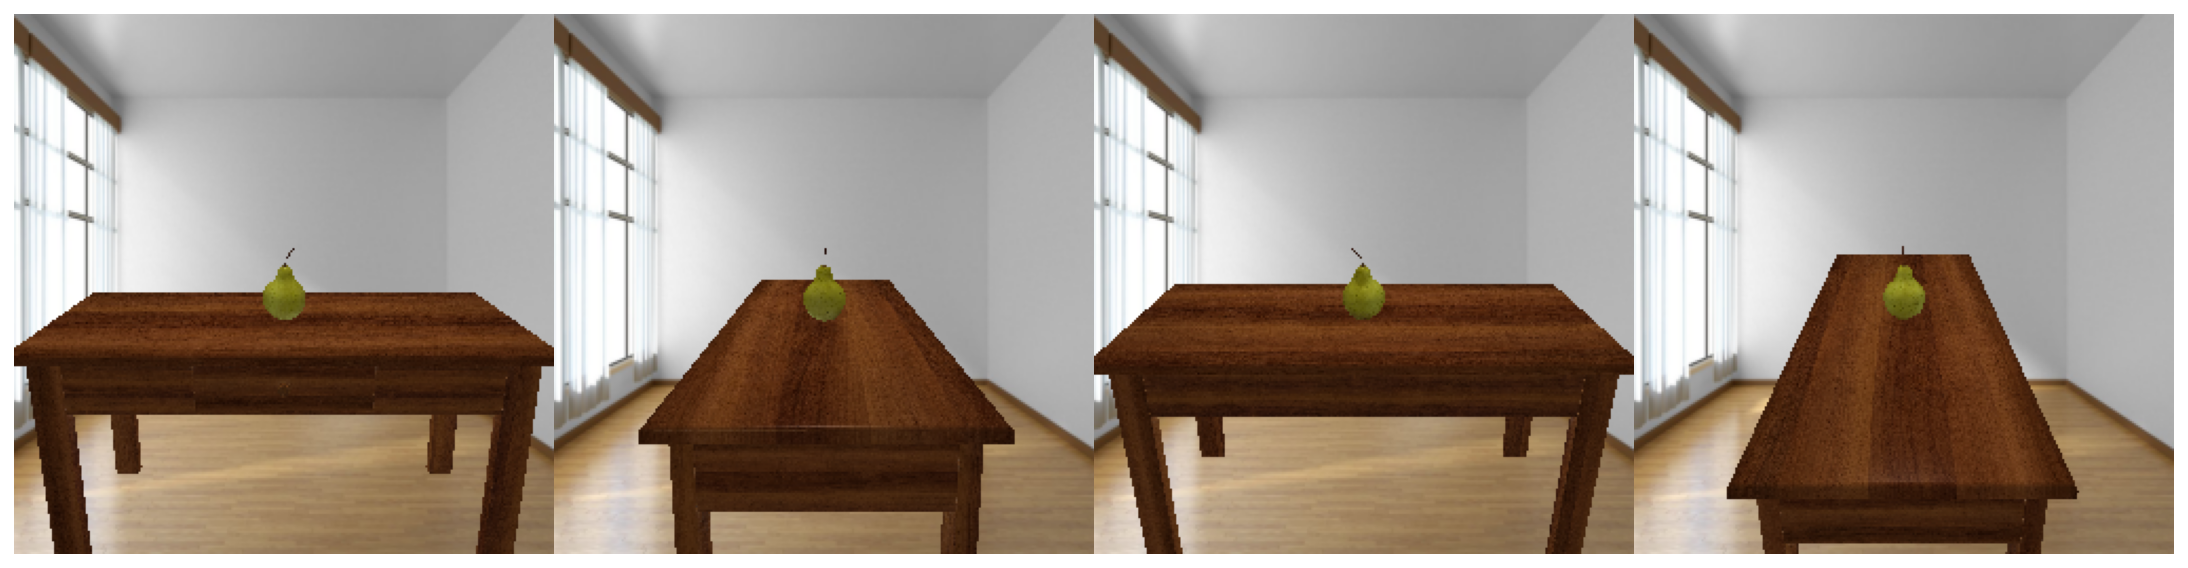

In [513]:
image_grid(env.best_images, rows=1, cols=4, rgb=True)

In [87]:
print(obs)

[0.301   0.09576 0.5195  0.0835 ]


In [94]:
plot_batch_individually(env.best_scene[0])

In [204]:
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

env = CustomTrain(50)
check_env(env, warn=True)

n_envs = 1

env = make_vec_env(lambda: env, n_envs=n_envs)

0.2791907890322927 [-1.3284309007447839, -1.2798602032721615, -1.9774068629915917, -1.4225896699440668] [0.265, 0.278, 0.1384, 0.2411]


AssertionError: ignored

In [78]:
n_steps = 50
total_timesteps = (n_steps * n_envs) * 40
train_model = PPO('MlpPolicy', env, verbose=1, n_steps=n_steps, gamma=0.4, learning_rate=0.2).learn(n_eval_episodes=10, total_timesteps=total_timesteps)

Using cuda device


/usr/local/lib/python3.7/dist-packages/stable_baselines3/ppo/ppo.py:147: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 50`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 50
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=50 and n_envs=1)
  f"You have specified a mini-batch size of {batch_size},"


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.67     |
|    ep_rew_mean     | 10       |
| time/              |          |
|    fps             | 4        |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 50       |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 5.21       |
|    ep_rew_mean          | 10         |
| time/                   |            |
|    fps                  | 4          |
|    iterations           | 2          |
|    time_elapsed         | 23         |
|    total_timesteps      | 100        |
| train/                  |            |
|    approx_kl            | 0.04512443 |
|    clip_fraction        | 0.224      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.24      |
|    explained_variance   | 0.00248    |
|    learning_rate        | 0.002      |
|   

KeyboardInterrupt: ignored

In [71]:
test_env = CustomTrain(50)

In [74]:
print(test_env.objs[0].position)

[-2.63, 3.06, -0.328]


In [75]:
# Test the trained agent
obs = test_env.reset()
print(test_env.objs[0].position)
_info = None
done = False
count = 0
while not done:
  count += 1
  action, _ = train_model.predict(obs, deterministic=True)
  obs, reward, done, info = test_env.step(action)

[-2.05, 0.5, 0.5]


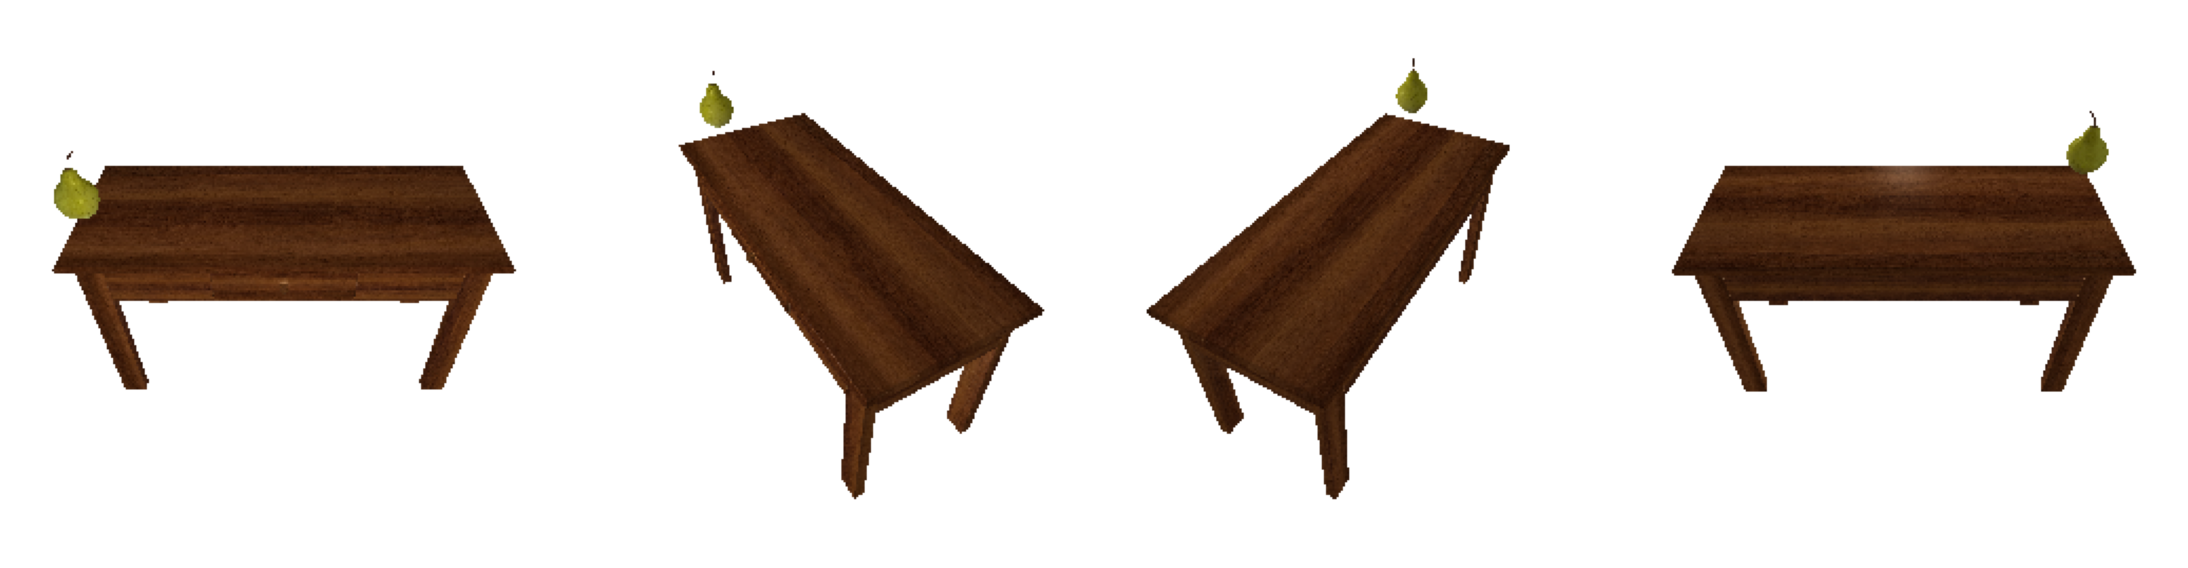

In [76]:
image_grid(test_env.best_images, rows=1, cols=4, rgb=True)

In [ ]:
# from sb3_contrib import TRPO

# model = TRPO("MlpPolicy", env, verbose=1).learn(total_timesteps=100, log_interval=4)

In [ ]:
# train_model = A2C("MlpPolicy", env, verbose=1).learn(n_eval_episodes=50, total_timesteps=1000)

In [ ]:
# from sb3_contrib import RecurrentPPO

# train_model = RecurrentPPO("MlpLstmPolicy", env, verbose=1, n_steps=128).learn(n_eval_episodes=200,total_timesteps=10000)

In [ ]:
# obs = env.reset()
# n_steps=10
# # cell and hidden state of the LSTM
# lstm_states = None
# num_envs = 1
# # Episode start signals are used to reset the lstm states
# episode_starts = np.ones((num_envs,), dtype=bool)
# _info = None
# for step in range(n_steps):
#     action, lstm_states = train_model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
#     obs, rewards, done, info = env.step(action)
#     _info = info
#     episode_starts = done

# image_grid(_info[0]["best"]["images"], rows=1, cols=4, rgb=True)

In [ ]:
# from stable_baselines3 import SAC

# train_model = SAC("MlpPolicy", env, verbose=1, device="cuda").learn(n_eval_episodes=100,total_timesteps=1000)

In [ ]:
# from stable_baselines3 import TD3
# from stable_baselines3.common.noise import NormalActionNoise

# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

In [ ]:
# train_model = TD3("MlpPolicy", env, train_freq=(5, "step"), action_noise=action_noise, verbose=1, device=device).learn(total_timesteps=1, log_interval=10)

In [ ]:
plot_batch_individually(best_scene[0])